<a href="https://colab.research.google.com/github/Luca-Massini/AN2DL-challenge/blob/master/custom_skip_connections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
import os

import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)

In [3]:
cwd = os.getcwd()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
projects=['Weedelec','Pead','Roseau','Bipbip']
plants=['Haricot','Mais']
path='/content/drive/Mydrive/Development_Dataset/Training/'
for project in projects :
      for plant in plants :
        path=os.path.join('/content/Development_Dataset/Training/',project,plant,'Images')
        print(path)


for i in range(3,1,-1) :
  print(i)

/content/Development_Dataset/Training/Weedelec/Haricot/Images
/content/Development_Dataset/Training/Weedelec/Mais/Images
/content/Development_Dataset/Training/Pead/Haricot/Images
/content/Development_Dataset/Training/Pead/Mais/Images
/content/Development_Dataset/Training/Roseau/Haricot/Images
/content/Development_Dataset/Training/Roseau/Mais/Images
/content/Development_Dataset/Training/Bipbip/Haricot/Images
/content/Development_Dataset/Training/Bipbip/Mais/Images
3
2


In [6]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect',
                                      rescale=1./255)
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect',
                                       rescale=1./255)

In [7]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256],validation_part=0.2,projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot','Mais']):
    self.png_or_jpg = []
    subset_filenames = []
    subset_direc = []
    for project in projects :
      for plant in plants :
        path=os.path.join(dataset_dir,project,plant)
        list_ = os.listdir(os.path.join(path,'Images')) # dir is your directory path
        number_files = len(list_)
        print(number_files) #remove after test

        training_num_max = int(number_files - int(number_files *  (1 - validation_part)))
        if which_subset == 'training':
          number_max = training_num_max
          for ii in range(0,number_max):
            subset_filenames.append(os.path.splitext(list_[ii])[0])
            subset_direc.append(path)
            if project!='Roseau':
              self.png_or_jpg.append(1)
            else:
              self.png_or_jpg.append(0)
        elif which_subset == 'validation':
          number_max = number_files - training_num_max
          for ii in range(number_files - 1, number_files - number_max, -1):
            subset_filenames.append(os.path.splitext(list_[ii])[0])
            subset_direc.append(path)
            if project!='Roseau':
              self.png_or_jpg.append(1)
            else:
              self.png_or_jpg.append(0)


    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_direc = subset_direc
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr
  
  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    curr_dir = self.subset_direc[index]
    if self.png_or_jpg[index] != 0:
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.jpg'))
    else:
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.png'))
    mask = Image.open(os.path.join(curr_dir, 'Masks', curr_filename + '.png'))

    # Resize image 
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)

    mask_arr = np.array(mask)
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    
    img_arr = np.array(img)
    mask_arr = new_mask_arr

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    #mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)


In [8]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 256
img_w = 256

dataset = CustomDataset('/content/drive/MyDrive/Development_Dataset/Training/', 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=None,validation_part=0.2,projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot'])
dataset_valid = CustomDataset('/content/drive/MyDrive/Development_Dataset/Training/', 'validation', 
                              preprocessing_function=None,validation_part=0.2,projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot'])

90
90
90
90
90
90
90
90


In [9]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
bs = 15
train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w,1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [10]:
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0. 1. 2.]


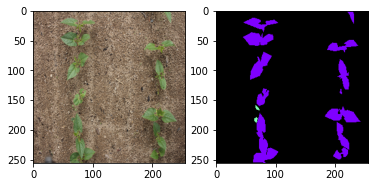

In [11]:

fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [ ]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()
for layer in vgg.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [14]:
def create_model(start_f, filter_shape = (3,3)):
  input_shape = [img_h, img_w, 3]

  inputs = tf.keras.Input(shape=(img_h, img_w, 3))
  x_1=  tf.keras.layers.Conv2D(filters = start_f, 
                              kernel_size = filter_shape,
                              strides=(1, 1),
                              padding='same',
                              input_shape=input_shape)(inputs)
  y_1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_1)

  start_f = start_f*2

  x_2=  tf.keras.layers.Conv2D(filters = start_f, 
                              kernel_size = filter_shape,
                              strides=(1, 1),
                              padding='same',
                              input_shape=input_shape)(y_1)
  y_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_2)

  start_f = start_f*2

  x_3=  tf.keras.layers.Conv2D(filters = start_f, 
                              kernel_size = filter_shape,
                              strides=(1, 1),
                              padding='same',
                              input_shape=input_shape)(y_2)
  y_3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_3)

  start_f = start_f*2

  x_4=  tf.keras.layers.Conv2D(filters = start_f, 
                              kernel_size = filter_shape,
                              strides=(1, 1),
                              padding='same',
                              input_shape=input_shape)(y_3)
  y_4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_4)

  start_f = start_f*2

  x_5=  tf.keras.layers.Conv2D(filters = start_f, 
                              kernel_size = filter_shape,
                              strides=(1, 1),
                              padding='same',
                              input_shape=input_shape)(y_4)
  y_5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_5)

  start_f /= 2

  x_6 = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(y_5)
  
  y_6 =tf.keras.layers.Conv2DTranspose(filters=start_f,
                                      kernel_size=(3, 3),
                                      strides=(1, 1),
                                      padding='same')(x_6)
  m_1 = tf.keras.layers.Average()([y_6,y_4])

  start_f /= 2

  x_7 = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(m_1)
  
  y_7 =tf.keras.layers.Conv2DTranspose(filters=start_f,
                                      kernel_size=(3, 3),
                                      strides=(1, 1),
                                      padding='same')(x_7)
  m_2 = tf.keras.layers.Average()([y_7,y_3])

  start_f /= 2

  x_8 = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(m_2)
  
  y_8 =tf.keras.layers.Conv2DTranspose(filters=start_f,
                                      kernel_size=(3, 3),
                                      strides=(1, 1),
                                      padding='same')(x_8)

  m_3 = tf.keras.layers.Average()([y_8,y_2])

  start_f /= 2

  x_9 = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(m_3)
  
  y_9 =tf.keras.layers.Conv2DTranspose(filters=start_f,
                                      kernel_size=(3, 3),
                                      strides=(1, 1),
                                      padding='same')(x_9)

  m_4 = tf.keras.layers.Average()([y_9,y_1])

  start_f /= 8

  x_10 = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(m_4)
  
  x_11 = tf.keras.layers.Average()([x_10,x_1])

  #last = tf.keras.layers.Average()([almost_finish, inputs])

  x_12 = tf.keras.layers.Conv2D(filters=3,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax')(x_11)
  
  outputs =tf.keras.layers.Conv2D(filters=3,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax')(x_12)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    
  return model

In [15]:
model = create_model(start_f=60, 
                     filter_shape=(3,3))

# Visualize created model as a table
model.summary()

# Visualize initialized weights
# model.weight

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 256, 256, 60) 1680        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 60) 0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 120 64920       max_pooling2d_5[0][0]            
_______________________________________________________________________________________

In [16]:

# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'multiclass_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
callbacks = []
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

Epoch 1/100
72/72 [==============================] - 2024s 28s/step - loss: 0.8966 - accuracy: 0.9212 - meanIoU: 7.2627e-04 - val_loss: 0.9052 - val_accuracy: 0.8889 - val_meanIoU: 3.9913e-12
Epoch 2/100
72/72 [==============================] - 1796s 25s/step - loss: 0.8782 - accuracy: 0.9470 - meanIoU: 2.3413e-11 - val_loss: 0.8922 - val_accuracy: 0.8889 - val_meanIoU: 3.9913e-12
Epoch 3/100
72/72 [==============================] - 1808s 25s/step - loss: 0.8635 - accuracy: 0.9471 - meanIoU: 2.3135e-11 - val_loss: 0.8794 - val_accuracy: 0.8889 - val_meanIoU: 3.9913e-12
Epoch 4/100
72/72 [==============================] - 1794s 25s/step - loss: 0.8490 - accuracy: 0.9474 - meanIoU: 2.4001e-11 - val_loss: 0.8669 - val_accuracy: 0.8889 - val_meanIoU: 3.9913e-12
Epoch 5/100
72/72 [==============================] - 1788s 25s/step - loss: 0.8353 - accuracy: 0.9470 - meanIoU: 2.3119e-11 - val_loss: 0.8546 - val_accuracy: 0.8889 - val_meanIoU: 3.9913e-12
Epoch 6/100
72/72 [=====================

UnknownError: ignored

In [18]:

import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

(1, 256, 256, 3)

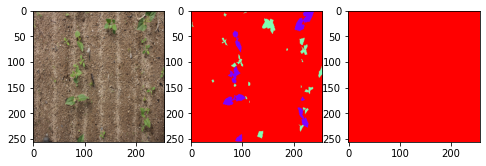

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(0, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(0, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

In [39]:
from PIL import Image

class CustomDataSol(tf.keras.utils.Sequence):

  def __init__(self, dataset_dir, img_generator=None,
               preprocessing_function=None, out_shape=[256, 256],projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot','Mais']):

    subset_filenames = []
    subset_direc = []
    name_project = []
    self.is_haricot_or_mais = []
    for project in projects :
      for plant in plants :
        path=os.path.join(dataset_dir,project,plant)
        list = os.listdir(os.path.join(path,'Images')) # dir is your directory path
        number_files = len(list)
        for ii in range(0,number_files):
          if plant == 'Haricot':
            self.is_haricot_or_mais.append(1)
          else:
            self.is_haricot_or_mais.append(0)
          subset_filenames.append(os.path.splitext(list[ii])[0])
          subset_direc.append(path)
          name_project.append(project)

    self.dataset_dir = dataset_dir
    self.projects = name_project
    self.subset_direc = subset_direc
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def get_plant_indexes(self):
    return self.is_haricot_or_mais

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    curr_dir = self.subset_direc[index]
    curr_project = self.projects[index]
    if curr_project == 'Roseau' :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.png'))
    else :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.jpg'))

    # Resize image 
    img = img.resize(self.out_shape)
    img_arr = np.array(img)
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [40]:
test_set=CustomDataSol('/content/drive/My Drive/Development_Dataset/Test_Dev/', 
                        img_generator=img_data_gen,
                        projects=['Weedelec','Pead','Roseau','Bipbip'],
                        plants=['Haricot', 'Mais'])
test_dataset = tf.data.Dataset.from_generator(lambda: test_set,
                                               output_types= tf.float32,
                                               output_shapes=[img_h, img_w, 3])

test_dataset = test_dataset.batch(1)
iterator = iter(test_dataset)
test_set.__len__()
    
submission_dict = {}
for index in range(0,test_set.__len__()):
  image = next(iterator)
  img_name = os.path.splitext(test_set.subset_filenames[index])[0]
  submission_dict[img_name] = {}
      

# load mask <- HERE you should have your segmentation model instead
  mask_arr =  model.predict(image)
  predicted_class = tf.argmax(mask_arr, -1)
  predicted_class = predicted_class[0, ...]
      
  prediction_img = np.zeros([target.shape[0], target.shape[1], 3])
  prediction_img[np.where(predicted_class == 0)] = 0
  for i in range(1, 3):
    prediction_img[np.where(predicted_class == i)] = i

  submission_dict[img_name]['shape'] = mask_arr.shape
  submission_dict[img_name]['team'] = test_set.projects[index]
  if test_set.get_plant_indexes()[index] == 0:
    submission_dict[img_name]['crop'] = 'Mais'
  else:
    submission_dict[img_name]['crop'] = 'Haricot'
  submission_dict[img_name]['segmentation'] = {}

    
    

  # RLE encoding
  # crop
  rle_encoded_crop = rle_encode(prediction_img == 1)
  # weed
  rle_encoded_weed = rle_encode(prediction_img == 2)

  submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
  submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

  # Please notice that in this example we have a single prediction.
  # For the competition you have to provide segmentation for each of
  # the test images.

# Finally, save the results into the submission.json file
import json
with open('/content/drive/My Drive/submission.json', 'w') as file:
        json.dump(submission_dict, file) 

120

In [ ]:
import os
import numpy as np
from PIL import Image


def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr


for i in range(0,1):

    # Read the example RGB mask and transform it into integer labels.

    mask = read_rgb_mask("./predictions/rgb_mask_example.png")

    np.save("./predictions/arr_mask_example.npy", mask)

In [ ]:
import os
import json
import numpy as np
from PIL import Image


def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


for i in range(0,1):

    # The submission file will be a zip file containing the a
    # submission.json file.

    # It must have the following structure:

    # - image name (without any extension, e.g., png, jpg, etc.)
    #   - shape: shape of the original image as list [Height, Width]
    #   - team: team of the original image. One in {'Bipbip', 'Pead', 'Roseau', 'Weedelec'}
    #   - crop: crop of the original image. One in {'Haricot', 'Mais'}
    #   - segmentation: prediction (as a dict)
    #     - crop: RLE encoded crop segmentation (no weed)
    #     - weed: RLE encoded weed segmentation (no crop)

    # Please refer to the folder structure of the given dataset to fill
    # the team and crop keys.

    # EXAMPLE:

    # Suppose that the numpy array generated with the
    # 'read_mask_example.py' script is the output of your segmentation model.
    # In addition, suppose that the team and crop of the segmented image
    # are 'Bipbip' and 'Haricot', respectively.
    # Then, in the following an example of submission file.

    img_name = 'arr_mask_example'

    # load mask <- HERE you should have your segmentation model instead
    mask_arr = np.load('./predictions/arr_mask_example.npy')

    submission_dict = {}
    submission_dict[img_name] = {}
    submission_dict[img_name]['shape'] = mask_arr.shape
    submission_dict[img_name]['team'] = 'Bipbip'
    submission_dict[img_name]['crop'] = 'Haricot'
    submission_dict[img_name]['segmentation'] = {}

    # RLE encoding
    # crop
    rle_encoded_crop = rle_encode(mask_arr == 1)
    # weed
    rle_encoded_weed = rle_encode(mask_arr == 2)

    submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
    submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

    # Please notice that in this example we have a single prediction.
    # For the competition you have to provide segmentation for each of
    # the test images.

    # Finally, save the results into the submission.json file
    with open('./predictions/submission.json', 'w') as f:
        json.dump(submission_dict, f)

In [ ]:
import os
import json
import numpy as np
from PIL import Image


def rle_decode(rle, shape):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


for i in range(0,1):

    # Just for completeness, here we show how the rle encoded mask
    # is transformed back to a numpy array

    # Read the submission.json file generated by the
    # 'prepare_submission.py' script
    with open('./predictions/submission.json', 'r') as f:
        submission_dict = json.load(f)

    img_name = 'arr_mask_example'
    img_shape = submission_dict[img_name]['shape']

    rle_encoded_crop = submission_dict[img_name]['segmentation']['crop']
    rle_encoded_weed = submission_dict[img_name]['segmentation']['weed']

    # Reconstruct crop and weed binary masks
    crop_mask = rle_decode(rle_encoded_crop, shape=img_shape)
    weed_mask = rle_decode(rle_encoded_weed, shape=img_shape)

    # Reconstruct original mask
    # weed_mask * 2 allows to convert ones into target 2 (weed label)
    reconstructed_mask = crop_mask + (weed_mask * 2)

    # Check that the RLE decoded mask is the same of the original mask
    # before the RLE encoding
    original_mask = np.load('./predictions/arr_mask_example.npy')

    np.testing.assert_allclose(original_mask, reconstructed_mask)

    # Just for visualisation purposes, save RGB reconstructed mask
    # Use again the dictionary in 'RGBtoTarget.txt'.
    reconstructed_rgb_arr = np.zeros(shape=img_shape + [3])
    reconstructed_rgb_arr[reconstructed_mask == 1] = [255, 255, 255]
    reconstructed_rgb_arr[reconstructed_mask == 2] = [216, 67, 82]

    reconstructed_rgb_img = Image.fromarray(
        np.uint8(reconstructed_rgb_arr))
    reconstructed_rgb_img.save('./predictions/rle_decoded_rgb_mask.png')

    # Please notice that the 'unknown' class corresponding to the
    # RGB value [216, 124, 18] is not considered for the evaluation
    # and thus does not appear in the reconstructed mask.